## Introduction

TEAMMATES: Akshat and Annie

The overall goal is to predict whether a payment by a company to a medical doctor or facility
was made as part of a research project or not.

### Imports

In [168]:
# data loading and manipulation
import pandas as pd
import numpy as np
import random

# scikit learn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

### Load data

The positive class corresponds to the payments that were made by a company to a doctor or facility that is part of the **research project**. The negative class on the other hand are the **general payments**. 

In the original data sets, the ratio of the positive class to the negative class is 1/20, making the positive class the minority class. 

Because the data sets are so large, we will subsample from the classes in order to maintain the same ratio. Thus we take 120K data points from Class 0, and 20K data points from Class 1. 

120K from the positive class turns out to be ~20% of the data, and 2M from the negative class is ~20% from the negative class. 

In [119]:
p = 0.2
df0 = pd.read_csv('Homework 3/payments2017/d0.csv', skiprows=lambda i: i>0 and random.random() > p)
df1 = pd.read_csv('Homework 3/payments2017/d1.csv', skiprows=lambda i: i>0 and random.random() > p)

/Users/antonialovjer/anaconda3/envs/aml/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (2,5,7,8,9,10,15,17,18,19,20,21,22,23,30,37,38,42,43,44,45,47,48,49,50,51,52,53,54,55,56,59,60,61,62,67,68,69,70,71,72,73,74,75,76,79,80,81,87,88,89,91,92,93,94,95,96,99,100,101,107,108,109,110,111,112,113,114,115,116,119,120,121,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,160,161,162,173,174,175) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [120]:
df0.shape

(2132667, 75)

In [121]:
df1.shape

(120385, 176)

** Feature Intersection **

There are 75 features present in the negative class, and 176 in the positive class. Our approach to combining the data sets for both the positive and the negative classs it to take an intersection of the features. 

In [122]:
notPrs = list(set(list(df1.columns)).difference(list(df0.columns)))
featureIntersection = list(set(list(df1.columns)).difference(notPrs))
print("There are {} features present in the intersection of the two dataframes.".format(len(featureIntersection)))

There are 64 features present in the intersection of the two dataframes.


In [123]:
df1 = df1[featureIntersection]
df0 = df0[featureIntersection]

Before we concatenate the two data sets, we add an indicator variable to each one specifying which class the data belongs to. We call this feature **target**, which is equal to 1 for the positive class and 0 for the negative class.

In [124]:
df1['Target'] = 1
df0['Target'] = 0

df = pd.concat([df1, df0], axis=0)
df.shape

(2253052, 65)

In [125]:
NAs = df.isna().mean().sort_values(ascending=False)

In [161]:
prelim = ['Recipient_Province', 
'Recipient_Postal_Code', 
'Recipient_Primary_Business_Street_Address_Line2',
'Teaching_Hospital_Name', 
'Teaching_Hospital_CCN',
'Teaching_Hospital_ID',
'Physician_Name_Suffix',       
'Program_Year', # because only 2017
'Physician_Profile_ID', # system generated unique identifier (IDs)
'Physician_Last_Name', 
'Physician_First_Name',
'Record_ID',
'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
'Physician_Profile_ID',
'Recipient_Zip_Code',
'Date_of_Payment',
'Physician_Middle_Name',       
]

In [162]:
dfTest = df.drop(columns=prelim, axis='columns')

In [163]:
dfTest.columns[dfTest.columns.str.contains('ID')]

Index([], dtype='object')

In [164]:
dfTest.shape

(2253052, 49)

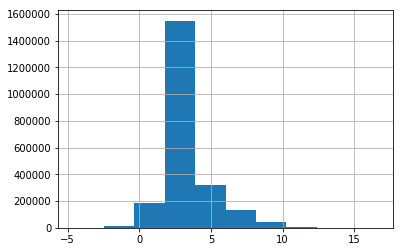

In [173]:
np.log(dfTest['Total_Amount_of_Payment_USDollars']).hist()


In [178]:
objVars = dfTest.select_dtypes(['object']).columns

dfTest.fillna('Missing', inplace=True)

target = dfTest['Target']
features = dfTest.drop(columns='Target')

preprocess = ColumnTransformer(
    ("dummies", OneHotEncoder(handle_unknown='ignore'), objVars)]
)



In [167]:
target = dfTest['Target']

colTransformer = ColumnTransformer()